<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/FastAI_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==2.0
import fastai 
print(fastai.__version__)
from fastai.vision.all import *

2.0.0


## Segmentation

Segmentation is a problem where we have to predict a category for each pixel of the image. For this task, we will use the [Camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/), a dataset of screenshots from cameras in cars. Each pixel of the image has a label such as "road", "car" or "pedestrian".

As usual, we can download the data with our `untar_data` function.

It seems the segmentation masks have the same base names as the images but with an extra `_P`, so we can define a label function: 

In [15]:



import imageio
from natsort import natsorted
import random
import warnings
warnings.filterwarnings("ignore")


!rm -rf trainimages
!mkdir trainimages
!rm -rf trainmasks
!mkdir trainmasks

!rm -rf validationimages
!mkdir validationimages
!rm -rf validationmasks
!mkdir validationmasks

!rm -rf testimages
!mkdir testimages
!rm -rf testmasks
!mkdir testmasks


!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pH5FgRRUPCmzbCszm101vAyTVe7Ufs60' -O ./Pt1.zip
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V4zAE19E1kLUK0Z0YIWNpMq0K8lOARtu' -O ./Pt2.zip
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=18mVgpUeghNOHKMazHLINyjq6lPKstLJp' -O ./Pt3.zip

!unzip -q -o "./Pt1.zip"
!unzip -q -o "./Pt2.zip"
!unzip -q -o "./Pt3.zip"
!mv *-Mask.jpg ./trainmasks
!mv *.jpg ./trainimages



!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Rh53wMdhEvOOel6z2c47uPW_R72I8dLe' -O ./Pt4.zip
!unzip -q -o "./Pt4.zip"
!mv *-Mask.jpg ./testmasks
!mv *.jpg ./testimages



--2020-09-02 16:48:19--  https://docs.google.com/uc?export=download&id=1pH5FgRRUPCmzbCszm101vAyTVe7Ufs60
Resolving docs.google.com (docs.google.com)... 74.125.128.113, 74.125.128.100, 74.125.128.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.128.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a8kota4q8g3k9q1jgb81gana7ocjh62o/1599065250000/16160187475894979440/*/1pH5FgRRUPCmzbCszm101vAyTVe7Ufs60?e=download [following]
--2020-09-02 16:48:24--  https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a8kota4q8g3k9q1jgb81gana7ocjh62o/1599065250000/16160187475894979440/*/1pH5FgRRUPCmzbCszm101vAyTVe7Ufs60?e=download
Resolving doc-0s-60-docs.googleusercontent.com (doc-0s-60-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-0s-60-docs.googleusercontent.com (doc-0s-60-

In [30]:
import pathlib

path = pathlib.Path(".")
flist = os.listdir("./trainimages")
fnames = []
for f in flist:
    fnames.append(pathlib.Path("./trainimages/" + f))

codes = ["BG", "Pancreas"]
print (fnames[0])
codes


trainimages/0076-00135.jpg


['BG', 'Pancreas']

In [32]:
#!ls ./trainimages/* | grep '1-00072'

def label_func(fn): return path/"trainmasks"/f"{fn.stem}-Mask{fn.suffix}"

We can then gather our data using `SegmentationDataLoaders`:

In [33]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

We do not need to pass `item_tfms` to resize our images here because they already are all of the same size.

As usual, we can have a look at our data with the `show_batch` method. In this instance, the fastai library is superimposing the masks with one specific color per pixel:

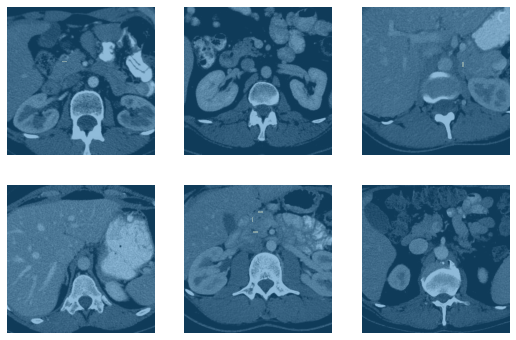

In [34]:
dls.show_batch(max_n=6)

A traditional CNN won't work for segmentation, we have to use a special kind of model called a UNet, so we use `unet_learner` to define our `Learner`:

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

And as before, we can get some idea of the predicted results with `show_results`

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

### With the data block API

We can also use the data block API to get our data in a `DataLoaders`. Like it's been said before, feel free to skip this part if you are not comfortable with learning new APIs just yet.

In this case we build the data block by providing:

- the types used: `ImageBlock` and `MaskBlock`. We provide the `codes` to `MaskBlock` as there is no way to guess them from the data.
- how to gather our items, here by using `get_image_files`.
- how to get the targets from our items: by using `label_func`.
- how to split the items, here randomly.
- `batch_tfms` for data augmentation.

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [ ]:
dls = camvid.dataloaders(path/"images", path=path, bs=8)

In [ ]:
dls.show_batch(max_n=6)

## Points

This section uses the data block API, so if you skipped it before, we recommend you skip this section as well.

We will now look at a task where we want to predict points in a picture. For this, we will use the [Biwi Kinect Head Pose Dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db). First thing first, let's begin by downloading the dataset as usual.

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

Let's see what we've got!

In [ ]:
path.ls()

There are 24 directories numbered from 01 to 24 (they correspond to the different persons photographed) and a corresponding .obj file (we won't need them here). We'll take a look inside one of these directories:

In [ ]:
(path/'01').ls()

Inside the subdirectories, we have different frames, each of them come with an image (`\_rgb.jpg`) and a pose file (`\_pose.txt`). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file.

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

We can have a look at our first image:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

In [ ]:
im.to_thumb(160)

The Biwi dataset web site explains the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same person appears in multiple images in this dataset — but we want to ensure that our model can generalise to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function which returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference to previous data block examples is that the second block is a `PointBlock`. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images.

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

Now that we have assembled our data, we can use the rest of the fastai API as usual. `cnn_learner` works perfectly in this case, and the library will infer the proper loss function from the data:

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
learn.lr_find()

Then we can train our model:

In [ ]:
learn.fine_tune(4, 5e-3)

The loss is the mean squared error, so that means we make on average an error of 

In [ ]:
math.sqrt(0.0001)

percent when predicting our points! And we can look at those results as usual:

In [ ]:
learn.show_results()